In [1]:
import sys 
import numpy as np
import  pandas as pd
import matplotlib.pyplot as plt 
from netCDF4 import Dataset
import matplotlib as mpl 
import matplotlib.colors as colors
import os

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Read the cluster ID assiged to each time step from the clustering results. You might need to modify this cell to fit your csv format**

In [3]:
## read the timestep and it's cluster ID from your clustering results
def read_combined_cluster(csvlink,varid):
    with open(csvlink, mode ='r')as file:
       # reading the CSV file
       csvFile = pd.read_csv(file)
       if(len(varid)>0):    
          id = csvFile['clusterid']
          time_step = csvFile['time_step']
          #days = np.zeros(len(id))-999 
          days=np.arange(len(time_step))
          #for i in range(len(id)): 
          #    print()  
          #    days[i] = int(time_step[i][5:])
                            
                            
    return days,id

In [4]:
# plot the map of orignal data (mean value and standard deviation) for each cluster on the specified subpanel
def plot_map(var, var_range,lon0,lat0,fig,panel,cmap0,colorbar,title,ifcontourf):
  ax=plt.subplot(panel)
  if(ifcontourf):  
     p1=plt.contourf(lon0,lat0,var,cmap=cmap0,levels=np.arange(var_range[0],var_range[1],(var_range[1]-var_range[0])/31),extend = 'both') 
     p1.ax.tick_params(labelsize=12)
     plotcoastline(color='k',)
     plt.xlim([min(lon0),max(lon0)])  
     plt.ylim([min(lat0),max(lat0)])    
     plt.title(title,loc='left')   
     plt.xlabel('Longitude')
     plt.ylabel('Latitude')
     if(colorbar):
        ticks = np.linspace(var_range[0], var_range[1], 8, endpoint=True)
        cax = ax.inset_axes([1.04, 0, 0.02, 1], transform=ax.transAxes)
        cb2 = fig.colorbar(p1,orientation='vertical',ax=ax,cax=cax,ticks=ticks)
        cb2.ax.tick_params(labelsize=9)
        
  else:
     p1=ax.contour(lon0,lat0,var,cmap=cmap0,levels=np.arange(var_range[0],var_range[1],(var_range[1]-var_range[0])/11),extend = 'both',linewidth=0.6) 
     p1.ax.tick_params(labelsize=12)
     plt.title(title,loc='right')
     if(colorbar):
        ticks = np.linspace(var_range[0], var_range[1], 12, endpoint=True)
        cax = ax.inset_axes([1.23, 0, 0.02, 1], transform=ax.transAxes)
        cb2 = fig.colorbar(p1,orientation='vertical',ax=ax,cax=cax,ticks=ticks)
        cb2.ax.tick_params(labelsize=9)
  ax.set_aspect(0.65)      

        #cbar = fig.colorbar(p1)
  return [p1]

In [5]:
##called by plot_map to plot the coastline on the map
def plotcoastline(color='k'):
    lon_c = []
    lat_c = []
    with open('./coast.txt') as f:
        for line in f:
            data = line.split()
            lon_c.append(float(data[0])-360)
            lat_c.append(float(data[1]))
    plt.plot(lon_c,lat_c,color=color,marker='s',markerfacecolor=color)
    return [lon_c,lat_c]

  **Map Visualization with original 2-dimensional dataset**

In [9]:
input_dir = './'
fig_dir = './'
data_file = '/content/drive/MyDrive/Multivariate Data Independent Study/New_ERA5_meteo_sfc_2021_daily.nc'
fcase = data_file
##Read time, lat and lon for visualization
fin = Dataset(fcase, "r")
time = np.squeeze(fin['time'][:])
lat0 = np.squeeze(fin['latitude'][:])
lon0 = np.squeeze(fin['longitude'][:])

#DBSCAN

# NO PCA SST

**Specify the variable name and it's unit coefficient here**

In [8]:
varids=['sst']  # Only considering SST can add or replace the following = ,'t2m','u10','v10','sshf','sp']
ccoefs=[1,-1./3600,1,1,-1./3600,1e-2]

**Specify the total subpanels for the visualized clusters. 4 rows x 2 columns for now:**

In [6]:
panels=np.arange(421,428,dtype=int) #4 rows 2 columns depending on clusters (how much panels you want?)
#You can choose different colormaps
cmap0='coolwarm'

**Plot the time series of the cluster ID:**

In [7]:
cluster_filename='DBscan_SST_No_PCA'
cluster_link = cluster_filename+'.csv'
[days,id]=read_combined_cluster(cluster_link,'OK') 
n_cluster = max(id)-min(id)+1
print('total clusters: ',n_cluster)

total clusters:  3


**Start plotting each individual variables: **

varid: sst
var_range: [286.9919318332959, 299.0668423730597]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: The following kwargs were not used by contour: 'linewidth'


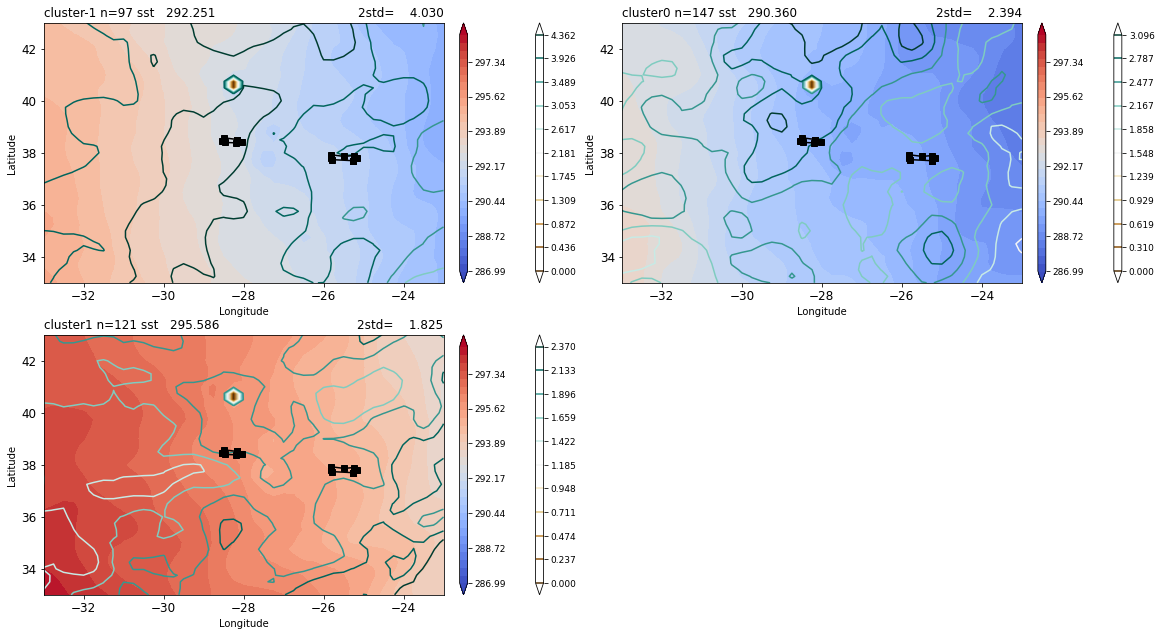

In [10]:

for ivar in range(len(varids)):
  fig=plt.figure(ivar+1,figsize=[19,22])  
  varid = varids[ivar]  
  var_range=[0,1]
  ccoef = ccoefs[ivar] 
  colorbar = True
  var0 = ccoef*np.squeeze(fin[varid][:])
  ## Fix the range of the values for all of the clusters
  var_range[0]= np.nanmin(var0)+(np.nanmax(var0)-np.nanmin(var0))*0.05
  var_range[1]=np.nanmax(var0)-(np.nanmax(var0)-np.nanmin(var0))*0.05
  print('varid:',varid)
  print('var_range:',var_range)
  ipanel = 0
  for icluster in range(min(id),max(id)+1):
      days_icluster = days[np.where(id==icluster)[0]]
      ndays_icluster = len(days_icluster)
      ## calculate the mean value and standard deviation from the time series of the variable at each (lat,lon)  
      time_icluster = np.zeros(ndays_icluster)
      var_icluster = np.zeros([ndays_icluster,len(lat0),len(lon0)])  
      for iday in range(ndays_icluster):
          istep = np.where(time==days_icluster[iday])
          time_icluster[iday] = time[istep]
          var_icluster[iday]=  np.squeeze(var0[istep])       
      var_mean_icluster = np.nanmean(var_icluster,axis=0)
      var_std_icluster = 2*np.nanstd(var_icluster,axis=0)
           
      title1= 'cluster'+str(icluster)+' n='+ str(len(time_icluster))+' '+varid+' '+ f'{np.nanmean(var_mean_icluster):9.3f}' 
      p = plot_map(var_mean_icluster, var_range,lon0,lat0,fig,panels[ipanel],cmap0,colorbar,title1,ifcontourf=True)
      if(np.nanstd(var_std_icluster)>1e-6*np.nanmean(var_std_icluster)):
          p = plot_map(var_std_icluster, [np.nanmin(var_std_icluster),np.nanmax(var_std_icluster)] ,lon0,lat0,fig,panels[ipanel],'BrBG',colorbar,'2std='+f'{np.nanmean(var_std_icluster):9.3f}',ifcontourf=False)
      else:
          print(np.nanstd(var_std_icluster),np.nanmean(var_std_icluster))
          plt.title('2std='+f'{np.nanmean(var_std_icluster):9.3f}',loc='right')
      ipanel += 1      
  #fig.savefig(varid+'_'+cluster_filename+'.jpg')


#plt.show()

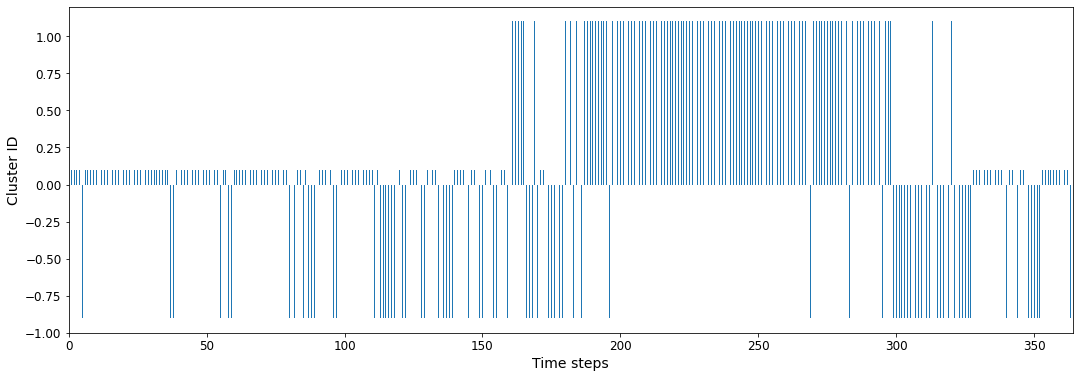

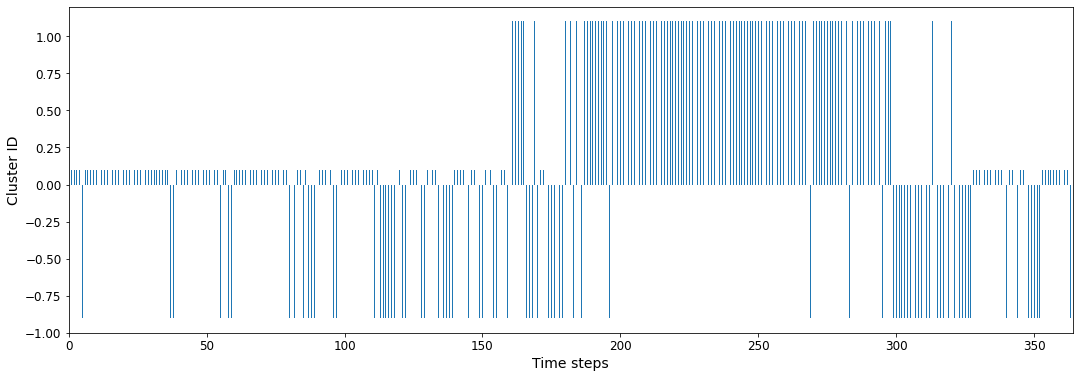

In [12]:
def barplot(ivar,days):
  fig=plt.figure(ivar+2,figsize=[18,6])
  plt.bar(days,id+0.1,width=0.3)
  plt.tick_params(labelsize=12)
  plt.xlim([min(days),max(days)])
  plt.ylabel('Cluster ID',fontsize=14)
  plt.xlabel('Time steps',fontsize=14)
  return fig

barplot(ivar,days)

#PCA SST ONLY

In [41]:
cluster_filename='DBscan_SST_PCA'
cluster_link = cluster_filename+'.csv'
[days,id]=read_combined_cluster(cluster_link,'OK') 
n_cluster = max(id)-min(id)+1
print('total clusters: ',n_cluster)

total clusters:  2


In [42]:
panels=np.arange(421,428,dtype=int) #4 rows 2 columns depending on clusters (how much panels you want?)
#You can choose different colormaps
cmap0='coolwarm'

In [44]:
varids=['sst']  # Only considering SST can add or replace the following = ,'t2m','u10','v10','sshf','sp']
ccoefs=[1,-1./3600,1,1,-1./3600,1e-2]

varid: sst
var_range: [286.9919318332959, 299.0668423730597]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: The following kwargs were not used by contour: 'linewidth'


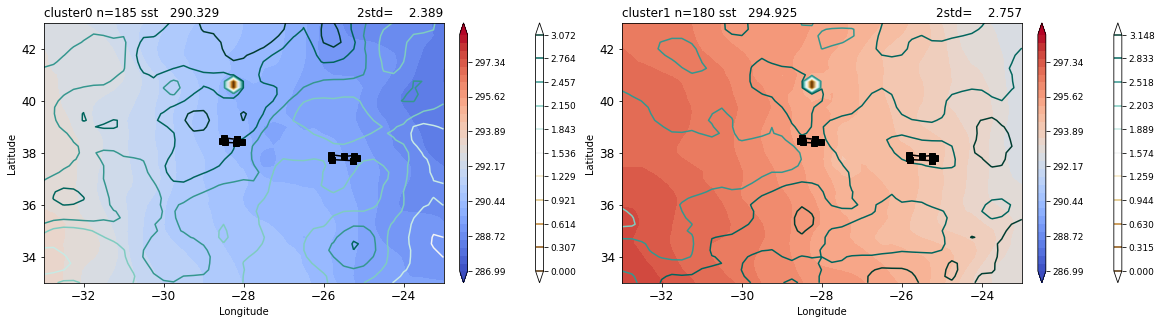

In [45]:
for ivar in range(len(varids)):
  fig=plt.figure(ivar+1,figsize=[19,22])  
  varid = varids[ivar]  
  var_range=[0,1]
  ccoef = ccoefs[ivar] 
  colorbar = True
  var0 = ccoef*np.squeeze(fin[varid][:])
  ## Fix the range of the values for all of the clusters
  var_range[0]= np.nanmin(var0)+(np.nanmax(var0)-np.nanmin(var0))*0.05
  var_range[1]=np.nanmax(var0)-(np.nanmax(var0)-np.nanmin(var0))*0.05
  print('varid:',varid)
  print('var_range:',var_range)
  ipanel = 0
  for icluster in range(min(id),max(id)+1):
      days_icluster = days[np.where(id==icluster)[0]]
      ndays_icluster = len(days_icluster)
      ## calculate the mean value and standard deviation from the time series of the variable at each (lat,lon)  
      time_icluster = np.zeros(ndays_icluster)
      var_icluster = np.zeros([ndays_icluster,len(lat0),len(lon0)])  
      for iday in range(ndays_icluster):
          istep = np.where(time==days_icluster[iday])
          time_icluster[iday] = time[istep]
          var_icluster[iday]=  np.squeeze(var0[istep])       
      var_mean_icluster = np.nanmean(var_icluster,axis=0)
      var_std_icluster = 2*np.nanstd(var_icluster,axis=0)
           
      title1= 'cluster'+str(icluster)+' n='+ str(len(time_icluster))+' '+varid+' '+ f'{np.nanmean(var_mean_icluster):9.3f}' 
      p = plot_map(var_mean_icluster, var_range,lon0,lat0,fig,panels[ipanel],cmap0,colorbar,title1,ifcontourf=True)
      if(np.nanstd(var_std_icluster)>1e-6*np.nanmean(var_std_icluster)):
          p = plot_map(var_std_icluster, [np.nanmin(var_std_icluster),np.nanmax(var_std_icluster)] ,lon0,lat0,fig,panels[ipanel],'BrBG',colorbar,'2std='+f'{np.nanmean(var_std_icluster):9.3f}',ifcontourf=False)
      else:
          print(np.nanstd(var_std_icluster),np.nanmean(var_std_icluster))
          plt.title('2std='+f'{np.nanmean(var_std_icluster):9.3f}',loc='right')
      ipanel += 1      
  #fig.savefig(varid+'_'+cluster_filename+'.jpg')


#plt.show()

Text(0.5, 0, 'Time steps')

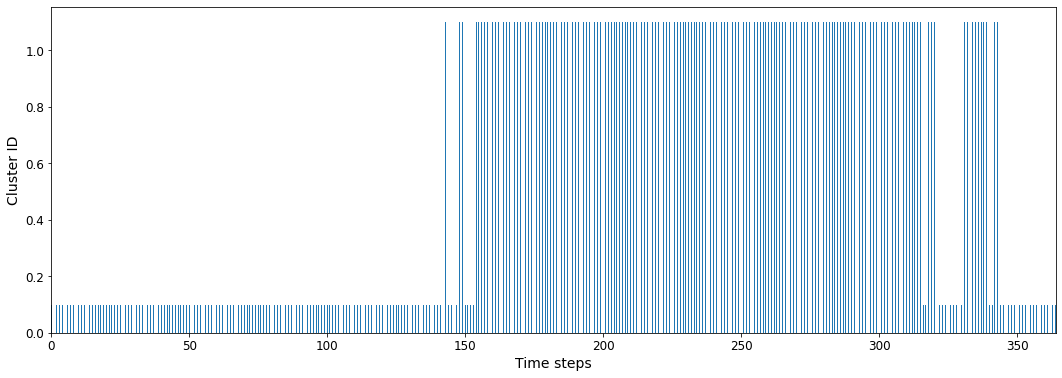

In [46]:
fig=plt.figure(ivar+2,figsize=[18,6])
plt.bar(days,id+0.1,width=0.3)
plt.tick_params(labelsize=12)
plt.xlim([min(days),max(days)])
plt.ylabel('Cluster ID',fontsize=14)
plt.xlabel('Time steps',fontsize=14)